<a href="https://colab.research.google.com/github/Udzf/Stat-Data-Science/blob/main/copie_Otter_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plan - Roadmap pour tt le monde



* Transposer le travail du mid-term sur le notebook
* Reprendre les remarques du mid-term
* Introduction: Commencer par un contexte, et ajouter findings de la revue littéraire
* Revue biblio
* Présentation de la méthodologie
* Multicollinearity analysis
* EDA des control variables
* Transposer l'équation du sujet
* Tables avec les résultats des régressions (VIF + OLS)
* GROSSE DISCUSSION DE LA CAUSALITE




In [15]:
!pip install stargazer
!pip install linearmodels
!pip install mplcursors==0.5.2

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor

from linearmodels.panel import PanelOLS
from stargazer.stargazer import Stargazer
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [17]:
waste_per_capita = pd.read_csv('https://raw.githubusercontent.com/gaojing33/Stat-Data-Science/refs/heads/main/filtered_waste_per_capita.csv')
merged_data = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/Panel_Data_Inc_Edu_Infl_Wm_Hh_Age_Urb.csv')

In [18]:
# Convert 'Country' and 'Year' to categorical variables (if not already)
merged_data['Country'] = merged_data['Country'].astype('category')
merged_data['Year'] = merged_data['Year'].astype('category')
merged_data.head()

,Country,Year,Waste,Income,Education,Women,Household,Age,Urban
0,Belgium,2014,484.672171,21705.0,32.6,62.9,2.3,41.3,0.97833
1,Bulgaria,2014,376.962939,3311.0,23.6,61.5,2.6,43.7,0.73651
2,Czechia,2014,310.164578,7622.0,19.1,64.7,2.4,40.8,0.73384
3,Denmark,2014,636.289226,27861.0,29.4,71.0,2.0,41.3,0.87410
4,Germany,2014,456.714036,19733.0,23.2,72.1,2.0,45.6,0.77190


In [19]:
print(merged_data.columns)

Index(['Country', 'Year', 'Waste', 'Income', 'Education', 'Women', 'Household',
       'Age', 'Urban'],
      dtype='object')




---



# Introduction

In [20]:
# Ensure we have country codes for plotting
iso_codes = {
    'Belgium': 'BEL', 'Bulgaria': 'BGR', 'Czechia': 'CZE', 'Denmark': 'DNK', 'Germany': 'DEU',
    'Estonia': 'EST', 'Ireland': 'IRL', 'Greece': 'GRC', 'Spain': 'ESP', 'France': 'FRA',
    'Croatia': 'HRV', 'Italy': 'ITA', 'Cyprus': 'CYP', 'Latvia': 'LVA', 'Lithuania': 'LTU',
    'Luxembourg': 'LUX', 'Hungary': 'HUN', 'Netherlands': 'NLD', 'Austria': 'AUT', 'Poland': 'POL',
    'Portugal': 'PRT', 'Romania': 'ROU', 'Slovenia': 'SVN', 'Slovakia': 'SVK', 'Finland': 'FIN',
    'Sweden': 'SWE', 'Iceland': 'ISL', 'Norway': 'NOR', 'Switzerland': 'CHE'
}

# Add the ISO-3 country codes to the DataFrame
waste_per_capita['iso_alpha'] = waste_per_capita['Country'].map(iso_codes)

# Convert waste per capita columns (2014-2022) to numeric, coercing errors to NaN
years = waste_per_capita.columns[1:-1]  # Exclude the 'Country' and 'iso_alpha' columns
waste_per_capita[years] = waste_per_capita[years].apply(pd.to_numeric, errors='coerce')

# Calculate the mean waste per capita across all years (2014–2022) for each country
waste_per_capita['mean_waste_per_capita'] = waste_per_capita[years].mean(axis=1)

# Create a choropleth map where the color reflects the mean waste per capita
fig = px.choropleth(
    waste_per_capita,
    locations="iso_alpha",  # Use the ISO-3 country codes
    color="mean_waste_per_capita",  # Use the calculated mean waste per capita for color gradient
    hover_name="Country",  # Show country name on hover
    color_continuous_scale="Blues",  # Use a color scale that indicates variation
    title="Mean Waste per Capita (2014–2022) in European Countries"
)

# Customize the map to focus on Europe
fig.update_geos(
    scope="europe",  # Focus the map on Europe
    projection_type="mercator",  # Use a flat Mercator projection
    showland=True,  # Show land in the map
    landcolor="lightgray",  # Color for land areas
    showcountries=True,  # Show country borders
    countrycolor="black"  # Country borders color
)

# Update layout for horizontal visuals
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, coastlinecolor="black"),
    height=1000,  # Decrease height for a more horizontal layout
    width=1000,  # Increase width to make the map horizontal
    margin={"r":0,"t":40,"l":0,"b":0}  # Adjust margins for better fitting
)

# Show the interactive map
fig.show()

#Data Transformation and Approximation



*   **Log transformation of net median income per capita:**
    By using the logarithmic transformation, the results now capture the effect of a 1% increase in net median income on household waste rather than absolute changes. This adjustment enhances interpretability and aligns the analysis with standard practices in panel data econometrics.



*   **Approximation:** Waste per capita data was bi-annual. For
    consistency with income data, we approximated the waste for odd years
    by averaging the surrounding even years




\begin{equation}
\text{Waste}_{i,t} = \beta_0 + \beta_1 \text{Income}_{i,t} + \beta_2 \text{Education}_{i,t} + \beta_3 \text{Household}_{i,t} + \beta_4 \text{Urban}_{i,t} + \beta_5 \text{Age}_{i,t} + \alpha_i + \gamma_t + \varepsilon_{i,t}
\end{equation}

#Country Fixed Effects
These capture country-specific factors that remain constant over time, such as:


*   Institutional difference like government policies
*   Long-Standing cultural attitudes toward waste generation



#Year Fixed Effects
These capture time-specific effects that impact all countries in the same way during a specific year, such as:

Global economic crises.

*   Global economic crisis
*   Advances in waste management technology or practices
*   Internation agreements on environmental standard





#**Endogeneity: The unseen forces**

In a regression, we assume the independent variables (the factors we think cause the outcome) are not related to any hidden factors in the model (the error term). If this assumption is violated, we have an endogeneity problem.

When endogeneity is present, your conclusions about cause and effect in the case become unreliable. You might end up accusing the wrong suspect because you didn’t untangle the evidence properly. Worse, you could miss the true criminal!

This is why we need to take some time to properly assess our potential sources of endogeneity. Are there any unobserved factors, reverse causality or errors in measurement that could mess with our investigation?


##**Selection bias:**
Our dataset includes 26 countries, of which 24 are from the EU. The selection was based on the availability of data from Eurostat. Many countries with insufficient information, such as Albania, Bosnia, and Montenegro, were not included in our analysis. These excluded countries are often poorer European nations, which may have lower sorting capacities or environmental constraints affecting their waste management practices. This suggests a potential selection bias in our analysis, as the dataset may overrepresent wealthier countries with more advanced waste management systems. To achieve more accurate results on a Europe-wide scale, it would be beneficial for further studies to include data from all 46 European countries.

##**Omitted Variables Bias (OVB):**
The impact of income per capita on household waste per capita is complex and influenced by numerous factors and variables. Based on the literature review, we focused on the most significant variables to ensure accuracy. However it is possible that some variables are missing from our investigation, potentially introducing omitted variable bias.

Examples of potential uncontrolled omitted variables:
* Behavioral factors: Higher-income households might adopt eco-friendly behaviorsthat reduce their waste production. Not including environmental awareness in the analysis may look like income drives lower waste more than in reality.
* Inhouse Tourism: As Airbnb and similar services have increased a lot recently in Europe, we might have an omitted variable as people benefitting from Airbnb services increase their income and visitors generate household waste.
* Access to waste management services: Wealthier countries or areas might have better access to recycling or waste collection which might play a role in how much waste households generate.
* Covid pandemic: The COVID-19 pandemic likely influenced both income and waste. Many households experienced income shocks due to job losses and waste was impacted both by economic downturn and lockdowns that forced people inside their houses, probably increasing waste from deliveries of food and goods.


##**Measurement Errors:**
Even though Eurostat follows a strict code of conduct for developing, producing, and disseminating statistics, it cannot compel countries to comply beyond their willingness to cooperate.
Some countries in our study may not fully meet Eurostat’s criteria for collecting and accounting for household waste. Additionally, due to the environmental significance of waste management, desirability bias could lead some countries to under-report household waste. Similarly, for net median income, certain individuals might systematically omit non-wage income to avoid higher taxation, introducing further inaccuracies.


##**Simultaneity:**
Household waste generation and income may simultaneously influence each other. While our regression assumes that income affects waste generation, the relationship could involve a feedback loop. For instance, in a country that valorizes waste through energy generation or material recovery via recycling, these economic activities could increase household income, which in turn leads to greater waste production, reinforcing the loop.


##**Instrumental Variables (IV):**
Instrumental variables (IV) are widely regarded as the gold standard for addressing endogeneity, often used to untangle complex relationships. A good IV must be strongly correlated with the independent variable (income) but have no direct effect on the dependent variable (waste generation) or the error term.

In our case we considered the Brexit impact on the income of european countries. But be patient, we will dive into this later..

# Literature Review

# Methods

In order to evaluate the impacts of the income, through consumption, on the generation of household waste, we used *X*. To control for *Y* due to factors other than *Z*, we included *V*. Furthermore, in order to control for unobservable differences among countries, we used a fixed effects estimator with country and year fixed effects. The
statistical specifications used follow the structure: *EQUATION*, where *W*.

*ajouter une table avec toutes les variables et leurs définitions*

# Results



# First Hint:

We now have all the necessary tools to successfully carry out this investigation. To see if our first insight as detectives was true, let's visualize whether our first assumption holds. As we can see in Figure X, there is a clear correlation between household waste and income. Our first assumption therefore holds true. However, as Detective Garbage knows well, there is still plenty of the unknown to uncover to prove causality in this pattern.


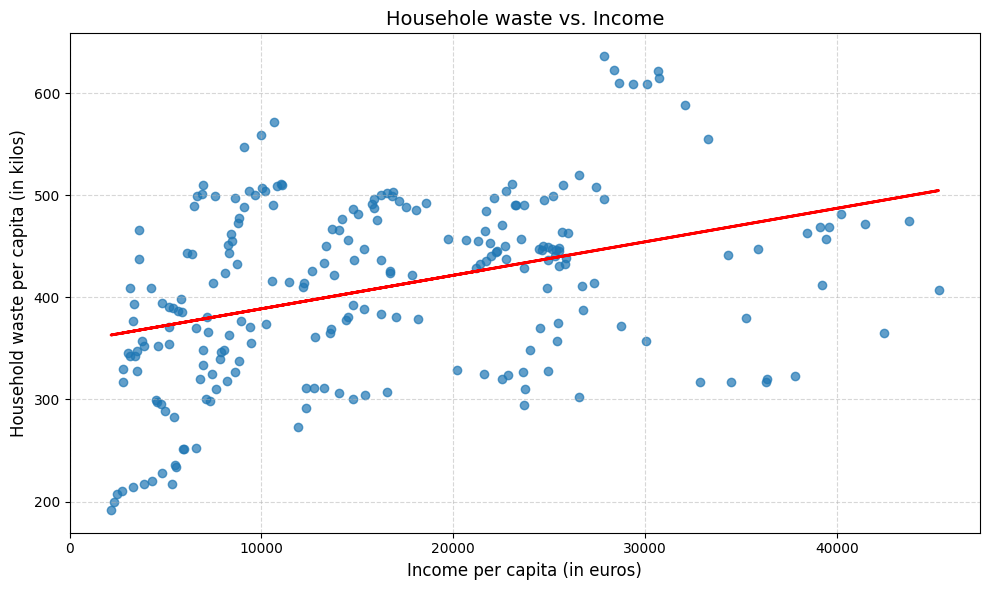

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors

new_data = merged_data[['Country', 'Year', 'Waste', 'Income']]
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size
scatter = ax.scatter(new_data['Income'], new_data['Waste'], alpha=0.7)  # Added transparency
plt.xlabel('Income per capita (in euros)', fontsize=12)
plt.ylabel('Household waste per capita (in kilos)', fontsize=12)  # Increased font size
plt.title('Househole waste vs. Income', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # Added gridlines

# Add a line of best fit
x = new_data['Income']
y = new_data['Waste']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color='red', linestyle='-', linewidth=2)  # Customized line style

# Add interactive annotations using mplcursors
cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect(
    "add", lambda sel: sel.annotation.set_text(f"{new_data['Country'][sel.target.index]} ({new_data['Year'][sel.target.index]})")
)
cursor.connect("add", lambda sel: sel.annotation.get_bbox_patch().set(fc="white", alpha=0.8))  # Annotation background


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

After running a linear regression on our two prime suspects — **median income per capita** and **household waste per capita** — a key clue emerges: the logarithm of income (Log_Income) has a positive and statistically significant connection with waste production.

The parameter for the logarithm of income is **108.74**, meaning that a **1% increase** **in income** increases household waste by **1.0874 kilograms**. The P-value, being lower than **0.01**, indicates **high statistical significance** in our results.

Detective, this is no coincidence. It seems economic growth leaves behind more than wealth — it leaves a growing trail of garbage. This connection is too strong to ignore, and it’s a crucial lead in solving the mystery of waste production.


In [22]:

from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*observed=False.*")

# Convert 'Country' and 'Year' to categorical variables (if not already)
merged_data['Country'] = merged_data['Country'].astype('category')
merged_data['Year'] = merged_data['Year'].astype('category')
merged_data['Year'] = merged_data['Year'].astype(int)  # Or float if years are not integers
merged_data = merged_data.set_index(['Country', 'Year'])
# Define the dependent variable (Y) and independent variables (X)
# Define dependent variable
Y = merged_data['Waste']

# Apply log transformation to the independent variable 'Income'
merged_data['Log_Income'] = np.log(merged_data['Income'])

# Define independent variable using log-transformed 'Income'
X = merged_data[['Log_Income']]

#... other parts of your code ...

X = merged_data[['Log_Income']]
# Add a constant term to the independent variables
X = sm.add_constant(X)
# Run the fixed effects model
# ...rest of your code...

# Run the fixed effects model
model = PanelOLS(dependent=Y, exog=X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='robust')
# Create a DataFrame with parameters and p-values
results_table = pd.DataFrame({'Parameter': results.params, 'P-value': results.pvalues})

# Display the table
display(results_table)

,Parameter,P-value
const,-620.242855,0.005156
Log_Income,108.740628,0.000005


By clustering the 26 countries into four income clusters (see Figure XX), we observe a clear increasing pattern in household waste per capita, reinforcing our initial hypothesis regarding the relationship between income per capita and household waste. However, we also notice that the difference within the highest income cluster is relatively small. This suggests that while richer countries tend to produce more household waste than poorer ones, this trend plateaus beyond a certain threshold. This indicates that income per capita is likely not the only variable influencing household waste, and that other factors need to be considered in our investigation to better understand the causal impacts of income on waste production. The work is far from finished! Go-go-go Garbage!.


In [23]:
# Calculate the average for each country across all years
country_averages = merged_data.groupby('Country')[['Waste', 'Income']].mean().reset_index()

In [24]:
new_data = merged_data[['Country', 'Year', 'Waste', 'Income']]

KeyError: "['Country', 'Year'] not in index"

In [ ]:
# Define the countries for each cluster
cluster1_countries = ['Romania', 'Bulgaria', 'Türkiye', 'Hungary', 'Poland', 'Lithuania','Lativa']
cluster2_countries = ['Slovakia', 'Czechia', 'Portugal','Estonia','Slovenia','Spain']
cluster3_countries = ['Malta', 'Cyprus', 'Italy','France','Germany','Belgium','Finland']
cluster4_countries = ['Denmark', 'Austria', 'Sweden', 'Ireland', 'Luxembourg','Norway']

# Create a new column 'Cluster' in the DataFrame
merged_data['Cluster'] = 0  # Initialize with 0

# Assign cluster numbers based on country
merged_data.loc[merged_data['Country'].isin(cluster1_countries), 'Cluster'] = 0
merged_data.loc[merged_data['Country'].isin(cluster2_countries), 'Cluster'] = 1
merged_data.loc[merged_data['Country'].isin(cluster3_countries), 'Cluster'] = 2
merged_data.loc[merged_data['Country'].isin(cluster4_countries), 'Cluster'] = 3

cluster_means = merged_data.groupby('Cluster')[['Waste', 'Income']].mean()

In [ ]:
# Create bar chart for Waste with custom cluster names
cluster_means['Waste'].plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of household waste across income clusters')
plt.xlabel('Mean of income per capita')
plt.ylabel('Mean of household waste per capita')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Custom cluster names
cluster_names = ['<7\'500 euros', '7\'501-15\'000 euros', '15\'001 - 25\'000 euros', '>25\'001 euros']
plt.xticks(range(len(cluster_names)), cluster_names, rotation = 0, ha='center')  # Set custom x-axis labels

plt.ylim(200, 500)
plt.show()

# DNA at our crime scene!

We now know that Income isn’t the only suspect in this case and that he probably has accomplices. Based on the literature review seen previously, we know that the mains confounding variable are the following:



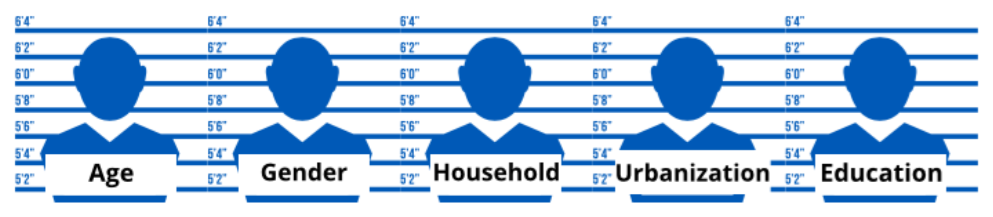

To determine which of these factors are relevant to our case, we will perform an Ordinary Least Squares (OLS) regression. This method will help us analyze which of these variables significantly impact our two main variables and therefore our results. It is in other words a sort of DNA test!

# Our OLS with confounding variable:

$$
\text{Waste}_{i,t} = \beta_0 + \beta_1 \text{Income}_{i,t} + \beta_2 \text{Education}_{i,t}
+ \beta_3 \text{Household}_{i,t} + \beta_4 \text{Urban}_{i,t} + \beta_5 \text{Age}_{i,t}
+ \beta_6 \text{Women}_{i,t} + \alpha_i + \gamma_t + \varepsilon_{i,t}
$$

- *Waste*$_{i,t}$: Waste generated in country $i$ at time $t$.
- *Income*$_{i,t}$: Average income level of the population in country $i$ at time $t$.
- *Education*$_{i,t}$: Percentage of the population in country $i$ at time $t$ with a higher education diploma (Bachelor, Master, PhD).
- *Household*$_{i,t}$: Average number of people per household in country $i$ at time $t$.
- *Urban*$_{i,t}$: Percentage of the population in country $i$ at time $t$ living in urban areas.
- *Age*$_{i,t}$: Average age of the population in country $i$ at time $t$.
- *Women*$_{i,t}$: Proportion of women in the workforce in country $i$ at time $t$.
- $\alpha_i$: Country fixed effects (unobserved heterogeneity across countries).
- $\gamma_t$: Time fixed effects (common time-specific factors).
- $\varepsilon_{i,t}$: Error term capturing unobserved influences.

After running the OLS regression (Appendix 2), we find that only two variables—Women and Urban—are not statistically significant when the full range of control variables is not accounted for. All other variables positively impact household waste per capita. We also observe that the coefficient of our main variable of interest—Income—is affected as additional variables are included.

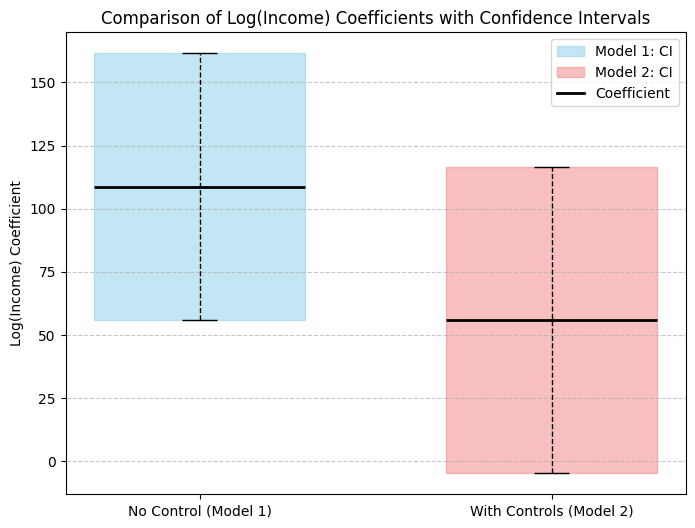

In [26]:

# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/Panel_Data_Inc_Edu_Infl_Wm_Hh_Age_Urb.csv')

# Ensure the DataFrame has a MultiIndex for PanelOLS
data = data.set_index(['Country', 'Year'])

# Add an intercept to the data explicitly
data['Intercept'] = 1

# Create Log_Income column
data['Log_Income'] = np.log(data['Income'])

# Define and fit the models
model1 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income']],
                  entity_effects=True,
                  time_effects=True).fit()

model2 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income', 'Education']],
                  entity_effects=True,
                  time_effects=True).fit()

model3 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income', 'Education', 'Household']],
                  entity_effects=True,
                  time_effects=True).fit()

model4 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income', 'Education', 'Household', 'Women']],
                  entity_effects=True,
                  time_effects=True).fit()

model5 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income', 'Education', 'Household', 'Women', 'Urban']],
                  entity_effects=True,
                  time_effects=True).fit()

model6 = PanelOLS(dependent=data['Waste'],
                  exog=data[['Intercept', 'Log_Income', 'Education', 'Household', 'Women', 'Urban', 'Age']],
                  entity_effects=True,
                  time_effects=True).fit()

# Create the Stargazer object
stargazer = Stargazer([model1, model2, model3, model4, model5, model6])

# Customize the table (optional)
stargazer.title('Panel OLS Regression Results with Time Effects')
stargazer.covariate_order(['Intercept', 'Log_Income', 'Education', 'Household', 'Women', 'Urban', 'Age'])

# Extract coefficients and confidence intervals
coef_model1 = model1.params['Log_Income']
ci_model1 = model1.conf_int().loc['Log_Income']

coef_model6 = model6.params['Log_Income']
ci_model6 = model6.conf_int().loc['Log_Income']

# Use .iloc explicitly to access lower and upper confidence intervals
data_plot = pd.DataFrame({
    'Model': ['Model 1', 'Model 6'],
    'Lower CI': [ci_model1.iloc[0], ci_model6.iloc[0]],
    'Upper CI': [ci_model1.iloc[1], ci_model6.iloc[1]],
    'Coefficient': [coef_model1, coef_model6]
})

# Plot
plt.figure(figsize=(8, 6))
for idx, row in data_plot.iterrows():
    # Draw confidence interval rectangles
    plt.gca().add_patch(plt.Rectangle(
        (idx - 0.3, row['Lower CI']),  # Bottom left corner (x, y)
        0.6,  # Width
        row['Upper CI'] - row['Lower CI'],  # Height
        color='skyblue' if row['Model'] == 'Model 1' else 'lightcoral',
        alpha=0.5
    ))
    # Add horizontal line for the coefficient
    plt.hlines(y=row['Coefficient'], xmin=idx - 0.3, xmax=idx + 0.3, color='black', linewidth=2)

    # Add vertical lines for the upper and lower limits
    plt.vlines(x=idx, ymin=row['Lower CI'], ymax=row['Upper CI'], color='black', linewidth=1, linestyle='--')

    # Add small dashes (ticks) at the upper and lower points
    plt.hlines(y=row['Lower CI'], xmin=idx - 0.05, xmax=idx + 0.05, color='black', linewidth=1)  # Lower tick
    plt.hlines(y=row['Upper CI'], xmin=idx - 0.05, xmax=idx + 0.05, color='black', linewidth=1)  # Upper tick

# Custom legend handles
legend_handles = [
    Patch(facecolor='skyblue', edgecolor='skyblue', alpha=0.5, label='Model 1: CI'),
    Patch(facecolor='lightcoral', edgecolor='lightcoral', alpha=0.5, label='Model 2: CI'),
    Line2D([0], [0], color='black', linewidth=2, label='Coefficient')
]

# Customization
plt.xticks([0, 1], ['No Control (Model 1)', 'With Controls (Model 2)'])
plt.ylabel('Log(Income) Coefficient')
plt.title('Comparison of Log(Income) Coefficients with Confidence Intervals')
plt.legend(handles=legend_handles, loc='upper right')  # Legend moved to the upper right
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As shown in Figure XXX, the coefficient of income decreases from 108.7 to 55.925, with both values remaining statistically significant. This indicates that when controlling for other variables, a 1% increase in income might leads to an increase of 0.559 kilos of household waste per capita, compared to the initially estimated 1.08 kilos. In other words, failing to include these additional variables would result in overestimating the impact of income on household waste. That’s a very interesting finding Detective Garbage, however we are still far to be done! Let’s continue the investigation!

# Brexit as an *IV*

Instrumental variables (IV) are widely regarded as the gold standard for addressing endogeneity, often used to untangle complex relationships. A good IV must be strongly correlated with the independent variable (income) but have no direct effect on the dependent variable (waste generation) or the error term.

In our case, we considered Brexit and its economic impact on some european countries. Brexit, which became fully effective in early 2020, introduced new trade barriers and uncertainty that impacted European countries differently, depending on how closely they traded with the UK. Countries that relied heavily on exporting goods to or importing goods from the UK felt a stronger economic jolt, which could affect their income levels. By not considering these differences, we might mistake Brexit-driven income changes for normal income fluctuations. This confusion can distort our estimates of how income really affects waste, leading to less reliable conclusions.

But don't worry Detective Garbage, we have the perfect tool to overthrow this effect!

# The 2SLS

To do our 2SLS, we created a dummy variable (a simple 0/1 indicator) to represent exposure to Brexit’s economic shock. Countries that had high trade exposure to the UK were coded as 1, and countries that did not were coded as 0. By focusing on the period from 2020 to 2022, we capture the years in which Brexit's economic effects would realistically be felt by European countries.
This 2SLS have two main steps:

First stage regression: We begin by checking whether our Brexit dummy (the instrument) can predict changes in median income. If countries marked as “1” (high exposure to Brexit) consistently show a noticeable change in income compared to those marked as “0” (low exposure), then our instrument is doing its job well.


$$
\hat{\text{Income}}_{i,t} = \beta_0 + \beta_2 \cdot IV_{i,t} + \beta_3 \cdot W_{i,t} + \varepsilon_{i,t}
$$

As we can see on Figure (XXX), the countries flagged by the Brexit dummy (set to 1) really do have a noticeably different in income growth during the year impacted (2020) than those not flagged (set to 0). This means the instrument is doing a good job! It provide us variation in income that stems specifically from Brexit-related factors. Moreover, we have a F-statistics results of 11.4, meaning that our IV is highly releavant. This variation can now be used in the second stage to estimate how income affects waste more accurately.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for linearmodels: filename=linearmodels-4.24-cp310-cp310-linux_x86_64.whl size=1982939 sha256=cd4aa32bc833ba63bd04b8e2d21e17ba91ed512390bbcbb6cb8ab5f57c460555
  Stored in directory: /root/.cache/pip/wheels/28/71/26/158a840e70e9b4b840fb15c9e015c5d5d2a8822823088f6a52
Successfully built linearmodels
  Attempting uninstall: linearmodels
    Found existing installation: linearmodels 6.1
    Uninstalling linearmodels-6.1:
      Successfully uninstalled linearmodels-6.1


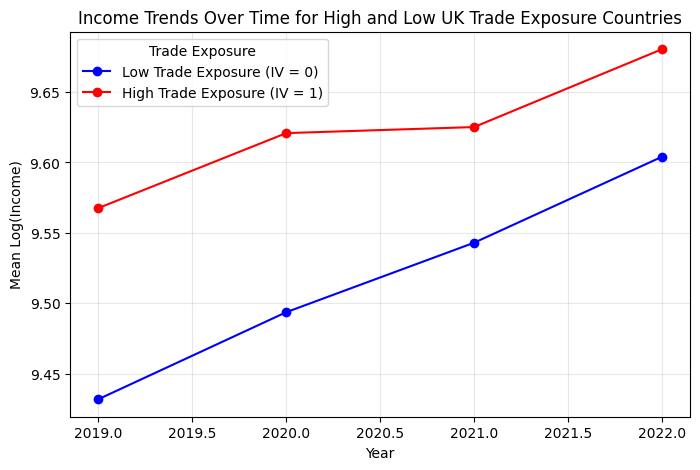

In [27]:
!pip install linearmodels==4.24
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Importing our merged and cleaned database
data2 = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/Panel_Data_Inc_Edu_Infl_Wm_Hh_Age_Urb.csv')



# Assuming your DataFrame is called 'data2'
data2['Log_Income'] = np.log(data2['Income'])



# Assuming your DataFrame is called 'data2'
# List of countries with value 0
countries_0 = ['Austria', 'Estonia', 'Finland', 'Hungary', 'Latvia', 'Lithuania', 'Luxembourg', 'Slovenia', 'Slovakia', 'Sweden', 'Bulgaria']

# Set 'Country' and 'Year' as index
data2 = data2.set_index(['Country', 'Year'])

# Create the 'UK trades' column and initialize with 1
data2['UK trades'] = 1

# Set values to 0 for specified countries
data2.loc[data2.index.get_level_values('Country').isin(countries_0), 'UK trades'] = 0

# Sort the MultiIndex
data2 = data2.sort_index()

# Filter for years 2020-2022
data2 = data2.loc[(slice(None), slice(2019, 2022)), :]

from linearmodels.iv import IV2SLS

# Define variables
y = data2['Waste']  # Dependent variable
X = data2[['Log_Income']]  # Endogenous regressor
Z = data2[['UK trades']]  # Instrumental variable
W = data2[['Education', 'Women', 'Household', 'Age', 'Urban']]  # Exogenous controls

# Run the IV model
model = IV2SLS(dependent=y, exog=W, endog=X, instruments=Z).fit()

# Calculate mean Log_Income for each year and cluster
income_trends = data2.groupby(['Year', 'UK trades'])['Log_Income'].mean().reset_index()

# Plot the trends
plt.figure(figsize=(8, 5))

# Custom colors
colors = {0: 'blue', 1: 'red'}

# Lineplot
for cluster in income_trends['UK trades'].unique():
    subset = income_trends[income_trends['UK trades'] == cluster]
    plt.plot(subset['Year'], subset['Log_Income'],
             color=colors[cluster],
             marker='o', linestyle='-',
             label=f"{'Low Trade Exposure (IV = 0)' if cluster == 0 else 'High Trade Exposure (IV = 1)'}")

# Customization
plt.title('Income Trends Over Time for High and Low UK Trade Exposure Countries')
plt.xlabel('Year')
plt.ylabel('Mean Log(Income)')
plt.legend(title='Trade Exposure')  # Legend with colors
plt.grid(alpha=0.3)
plt.show()



The second stage regression: we then use the portion of income variation explained by Brexit (from the first stage) and regress household waste on that. This gives us a cleaner estimate of how changes in income (stemming from Brexit’s trade shock) affect household waste.

$$
\text{Waste}_{i,t} = \beta_0 + \beta_1 \cdot \hat{\text{Income}}_{i,t} + \beta_2 \cdot W_{i,t} + \varepsilon_{i,t}
$$

By doing this new regression we find an interesting results for our main suspect income. As we can see in Figure (XXXX), it's coefficient increase from 55.9 to 98.3, with both value being statically significant. Running the regression without our IV would therefore have underestimated the impact of Income on waste.

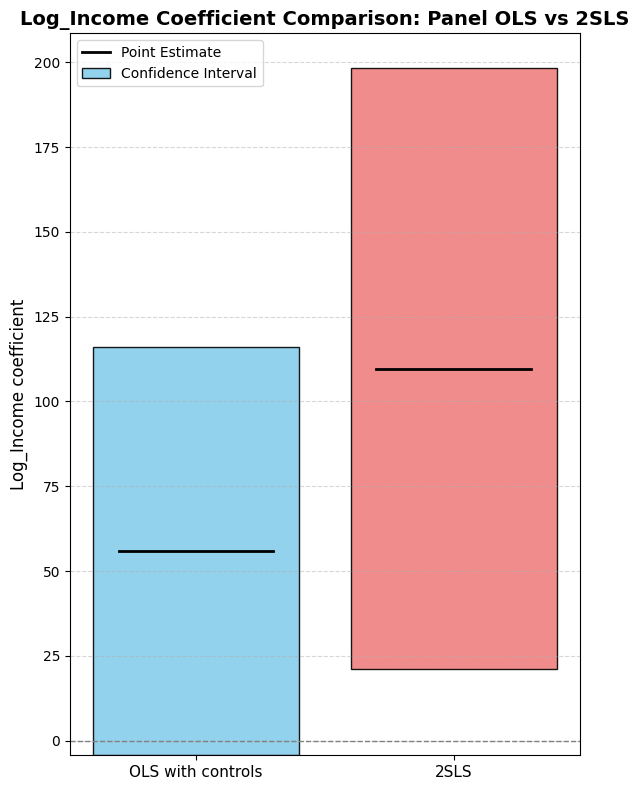

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS

# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/Panel_Data_Inc_Edu_Infl_Wm_Hh_Age_Urb.csv')
data = data.set_index(['Country', 'Year'])
data['Intercept'] = 1
data['Log_Income'] = np.log(data['Income'])

# ----------------------
# Panel OLS (Model 6)
# ----------------------
model6 = PanelOLS(
    dependent=data['Waste'],
    exog=data[['Intercept', 'Log_Income', 'Education', 'Household', 'Women', 'Urban', 'Age']],
    entity_effects=True,
    time_effects=True
).fit()

# Extract coefficients and CIs for Log_Income
panel_coef = model6.params['Log_Income']
panel_se = model6.std_errors['Log_Income']
panel_lower_ci = panel_coef - 1.96 * panel_se
panel_upper_ci = panel_coef + 1.96 * panel_se

# ----------------------
# 2SLS
# ----------------------
# Assuming data2 is similar to `data` for 2SLS
data = data.copy()
y = data2['Waste']
X = data2[['Log_Income']]
Z = data2[['UK trades']]  # Ensure 'UK trades' exists in your dataset
W = data2[['Education', 'Women', 'Household', 'Age', 'Urban']]

# Run 2SLS
model_iv = IV2SLS(dependent=y, exog=W, endog=X, instruments=Z).fit()

# Extract coefficients and CIs for Log_Income
iv_coef = model_iv.params['Log_Income']
iv_se = model_iv.std_errors['Log_Income']
iv_lower_ci = iv_coef - 1.96 * iv_se
iv_upper_ci = iv_coef + 1.96 * iv_se

# ----------------------
# Combine Results into a DataFrame
# ----------------------
results = pd.DataFrame({
    'Model': ['OLS with controls', '2SLS'],
    'Coefficient': [panel_coef, iv_coef],
    'Lower CI': [panel_lower_ci, iv_lower_ci],
    'Upper CI': [panel_upper_ci, iv_upper_ci]
})

# ----------------------
# Plot the Results
# ----------------------
plt.figure(figsize=(6, 8))

# Updated colors for the rectangles
colors = ['skyblue', 'lightcoral']

# Plot confidence intervals as bars (rectangles)
plt.bar(
    results['Model'],
    results['Upper CI'] - results['Lower CI'],  # Height of the bars
    bottom=results['Lower CI'],  # Starting point
    color=colors,  # Updated colors
    alpha=0.9,
    edgecolor='black',  # Add edges for clarity
    label='Confidence Interval'
)

# Add lines for coefficients
for i, coef in enumerate(results['Coefficient']):
    plt.plot([i - 0.3, i + 0.3], [coef, coef], color='black', lw=2, label='Point Estimate' if i == 0 else "")

# Customize the plot
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Zero reference line
plt.title('Log_Income Coefficient Comparison: Panel OLS vs 2SLS', fontsize=14, weight='bold')
plt.ylabel('Log_Income coefficient', fontsize=12)
plt.xticks(ticks=range(len(results)), labels=results['Model'], fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Discussion



*   Age: les vieux consomment moins + les vieux ont plus tendance à acheter pour les autres
*   Élément de liste



# Appendix

# Multicollinearity analysis

In this section, we analyze the multicollinearity of our variables using a correlation matrix and Variance Inflation Factor (VIF) indicators.

The correlation matrix reveals several interesting relationships among the variables. Overall, most correlations are moderate or low, indicating limited multicollinearity. The exception is the correlation between household size and the proportion of women in the workforce, which is high. To confirm our intuition that keeping it in the regression is relevant, we have calculated the Variance Inflation Factors (VIF), which assess how much multicollinearity we have between our controls. The rule of thumb is that a VIF greater than 5 suggests it is better to drop the variable of the regression, which was not the case here.


In [ ]:
# Select the control variables
controls = merged_data[['Income', 'Education', 'Women', 'Household', 'Age', 'Urban']]

# Compute the correlation matrix
correlation_matrix = controls.corr()

# Create a mask for the upper triangle, excluding the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Create a heatmap with the reversed color scale and mask
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask,  # Mask the upper triangle but keep the diagonal
    annot=True,
    fmt='.2f',
    cmap='viridis_r',  # Reversed color scale
    cbar=True,
    square=True,
    linewidths=0.5,  # Adds light grid lines for visual separation
    annot_kws={"size": 10}  # Annotation text size
)
plt.title('Correlation Matrix', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Select the control variables
controls = merged_data[['Education', 'Women', 'Household', 'Age', 'Urban']]

# Add a constant column for VIF calculation
controls_with_const = sm.add_constant(controls)

# Calculate VIF for each variable
vif_data = pd.DataFrame({
    'Variable': controls_with_const.columns,
    'VIF': [variance_inflation_factor(controls_with_const.values, i) for i in range(controls_with_const.shape[1])]
})

# Drop the constant term from the table
vif_data = vif_data[vif_data['Variable'] != 'const']

# Display the VIF table in Colab
print(vif_data)

In [ ]:
html_table_code = """
<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable: Waste</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr>

<tr><td style="text-align:left">Intercept</td><td>-620.243<sup>**</sup></td><td>-816.472<sup>***</sup></td><td>-1227.276<sup>***</sup></td><td>-1230.998<sup>***</sup></td><td>-1868.196<sup>***</sup></td><td>-1367.345<sup>**</sup></td></tr>
<tr><td style="text-align:left"></td><td>(253.627)</td><td>(264.489)</td><td>(292.511)</td><td>(289.875)</td><td>(712.891)</td><td>(689.016)</td></tr>
<tr><td style="text-align:left">Log_Income</td><td>108.741<sup>***</sup></td><td>112.101<sup>***</sup></td><td>119.333<sup>***</sup></td><td>91.748<sup>***</sup></td><td>101.228<sup>***</sup></td><td>55.925<sup>*</sup></td></tr>
<tr><td style="text-align:left"></td><td>(26.772)</td><td>(26.515)</td><td>(26.093)</td><td>(28.876)</td><td>(30.461)</td><td>(30.745)</td></tr>
<tr><td style="text-align:left">Education</td><td></td><td>5.554<sup>**</sup></td><td>5.467<sup>**</sup></td><td>4.198<sup>*</sup></td><td>4.240<sup>*</sup></td><td>7.548<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td></td><td>(2.375)</td><td>(2.327)</td><td>(2.381)</td><td>(2.382)</td><td>(2.387)</td></tr>
<tr><td style="text-align:left">Household</td><td></td><td></td><td>144.364<sup>***</sup></td><td>150.841<sup>***</sup></td><td>164.891<sup>***</sup></td><td>105.811<sup>**</sup></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td>(47.647)</td><td>(47.313)</td><td>(49.450)</td><td>(48.955)</td></tr>
<tr><td style="text-align:left">Women</td><td></td><td></td><td></td><td>4.261<sup>**</sup></td><td>4.488<sup>**</sup></td><td>1.751<sup></sup></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td>(1.986)</td><td>(1.999)</td><td>(2.001)</td></tr>
<tr><td style="text-align:left">Urban</td><td></td><td></td><td></td><td></td><td>676.416<sup></sup></td><td>-988.093<sup></sup></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td>(691.366)</td><td>(755.803)</td></tr>
<tr><td style="text-align:left">Age</td><td></td><td></td><td></td><td></td><td></td><td>33.089<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td><td></td><td></td><td>(7.340)</td></tr>

<td colspan="7" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align: left">Observations</td><td>234</td><td>234</td><td>234</td><td>234</td><td>234</td><td>234</td></tr><tr><td style="text-align: left">N. of groups</td><td>26</td><td>26</td><td>26</td><td>26</td><td>26</td><td>26</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.077</td><td>0.101</td><td>0.141</td><td>0.161</td><td>0.165</td><td>0.244</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>10.834 (df=199)</td><td>12.499 (df=198)</td><td>14.798 (df=197)</td><td>15.836 (df=196)</td><td>16.077 (df=195)</td><td>19.603 (df=194)</td></tr><tr><td style="text-align: left">F Statistic</td><td>16.498<sup>***</sup> (df=35; 199)</td><td>11.169<sup>***</sup> (df=36; 198)</td><td>10.813<sup>***</sup> (df=37; 197)</td><td>9.410<sup>***</sup> (df=38; 196)</td><td>7.718<sup>***</sup> (df=39; 195)</td><td>10.456<sup>***</sup> (df=40; 194)</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td><td colspan="6" style="text-align: right"><sup>*</sup>p&lt;0.1; <sup>**</sup>p&lt;0.05; <sup>***</sup>p&lt;0.01</td></tr></table>
"""

# Render the HTML table
from IPython.core.display import display, HTML
display(HTML(html_table_code))

Waaoue! Don’t be scared like this Detective Garbage! I’m pretty sure that a graduated EPFL student from criminology will have no issue understanding the outcome of a simple linear regression! Let me help you through it!

The first column on the left, marked with a little (1) at the top, represents our first linear regression. Remember? The one we did previously, comparing only the impact of the logarithm of income on household waste. Then, as you move to the columns on the right, we add one variable at a time. The second column with the little (2) at the top is the same linear regression as the first one but with the variable education added. The third column is the same linear regression as the first one but with the variable education and household added, and so on until all the variables are added to the same equation! You see? Easy!

And what about the little stars above the numbers, ranging from one to three? These stars indicate statistical significance. As long as there is a star, the variable is statistically significant in our equation, meaning it has a meaningful impact on the results.


# References